VAE with disentanglement

In [1]:
# Syllabus - auto encoder (AE)
# http://www.xavierdupre.fr/app/ensae_teaching_dl/helpsphinx//chapters/deep_apprentissage_sans_labels.html

In [5]:
# Que sont les auto-encodeurs
# https://blog.keras.io/building-autoencoders-in-keras.html

In [6]:
#Awesome-Pytorch-list
#https://github.com/bharathgs/Awesome-pytorch-list

In [7]:
#https://ml-cheatsheet.readthedocs.io/en/latest/

In [8]:
# =================
# autocompletion
# =================
%config IPCompleter.greedy=True

In [9]:
# importer les libraries
from __future__ import print_function
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt

In [10]:
# Debut du decompte du temps
import time
start_time = time.time()

In [11]:
#== sanity check : library cuda est-elle presente ?
torch.cuda.is_available()

False

In [12]:
#== sanity check : presence du framework cudnn ?
torch.backends.cudnn.enabled

True

In [13]:
# reproductibilite
SEED = 1
torch.manual_seed(SEED)

In [14]:
# parametrer a la main (ne pas passer par argparse)
batchsize=BATCH_SIZE= 128
EPOCHS = 15
loginterval =LOG_INTERVAL = 10
CUDA = True
cuda = torch.cuda.is_available()

In [15]:
# declaration de la var d'espace latent
ZDIMS = 20

In [16]:
device = torch.device("cuda" if cuda else "cpu")
device

device(type='cpu')

In [17]:
# instances de DataLoader chargent les tenseurs in cuda-memory 
kwargs = {'num_workers': 11, 'pin_memory': True} if cuda else {}

In [18]:
# formation des dataset train et test a partir de Mnist
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batchsize, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batchsize, shuffle=True, **kwargs)

In [19]:
# sanity check
len(train_loader.dataset)

60000

In [20]:
# sanity check
len(test_loader.dataset)

10000

In [21]:
# declaration du modele VAE

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
# encodeur
        self.fc1 = nn.Linear(784, 400)
        self.relu = nn.ReLU()
        self.fc21 = nn.Linear(400, ZDIMS)
        
        self.fc22 = nn.Linear(400, ZDIMS)

# decodeur        
        self.fc3 = nn.Linear(ZDIMS, 400)
        self.fc4 = nn.Linear(400, 784)
        self.sigmoid = nn.Sigmoid()

# sorties(mu, logvar): 
# moy et var, une pour chaque dimension latente, 

    def encode(self, x: Variable) -> (Variable, Variable):
        h1 = self.relu(self.fc1(x))  
        return self.fc21(h1), self.fc22(h1)

# sur train
# - prenez mu, var appris pour chacune des dimensions de ZDIMS et tirez échantillon
# aléatoire de cette distribution    
# - l'ensemble du réseau est formé de sorte que ces échantillons dessinés au 
# hasard se décodent en sortie qui ressemble à l'entrée    
# - ce qui signifie que mu, var sera appris des distributions qui codent 
# les entrées    
# - en raison du terme KLD supplémentaire (voir loss_function () 
# ci-dessous), la distribution aura tendance à unifier les Gaussiens     

    
    def reparameterize(self, mu: Variable, logvar: Variable) -> Variable:
        if self.training: 
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z: Variable) -> Variable:
        h3 = self.relu(self.fc3(z))
# l'utilisation de la sigmoid est adaptée à nos données car nous manipulons en entrée des images N&B donc on 
# a des valeurs (après normalisation entre 0 et 1) , et la forme de la sigmoide convient bien ici
        return self.sigmoid(self.fc4(h3)) 

    def forward(self, x: Variable) -> (Variable, Variable, Variable):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

model = VAE()
model.to(device)   
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [22]:
# KLD est la deviation Kullback-Leibler

def loss_function(recon_x, x, mu, logvar) -> Variable:
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784))
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
# Normaliser par le même nombre d'éléments que dans la reconstruction 
    KLD /= BATCH_SIZE * 784
    return BCE + KLD

In [31]:
losses = []

def train(epoch):
   
    model.train()
    train_loss = 0
    
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)

        ########################################
        # Pour conserver les valeurs du gradient
        # Ne marche pas à l'ENSEEITH : 
        # RuntimeError: the derivative for 'target' is not implemented with binary_cross_entropy
        # data.requires_grad = True
        ########################################
        data = data.to(device)
        optimizer.zero_grad()

        ########################################
        # Pour conserver les valeurs du gradient
        # Ne marche pas à l'ENSEEITH
        # Récupérer la valeur de data.grad et la conserver dans un tableau Tab_Gradient
        ########################################        
        recon_batch, mu, logvar = model(data)
       
        loss = loss_function(recon_batch, data, mu, logvar)
        
        losses.append(loss.cpu().item())
        
        loss.backward()
        
        #train_loss += loss.data[0]
        train_loss += loss.item()
        
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                #loss.data[0] 
                loss.item()/ len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

In [32]:
def test(epoch):
  
    model.eval()
    test_loss = 0
    
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            # on force le device par détecté
            data = data.to(device)

            data = Variable(data, volatile=False)
            recon_batch, mu, logvar = model(data)
        
            #test_loss += loss_function(recon_batch, data, mu, logvar).data[0]
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
        
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(BATCH_SIZE, 1, 28, 28)[:n]])
          
                save_image(comparison.data.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [33]:
for epoch in range(1, EPOCHS + 1):
    train(epoch)
    test(epoch)

# 64 ensembles de vecteurs ZDIMS-float aléatoires, soit 64 emplacements / MNIST   
    sample = Variable(torch.randn(64, ZDIMS))
    
    with torch.no_grad():
            sample = sample.to(device)
            sample = model.decode(sample).cpu()
            
            save_image(sample.data.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')
               

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.001203
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.001195
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.001154
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.001138
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.001182
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.001142
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.001195
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.001167
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.001118
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.001157
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.001154
Train Epoch: 1 [14080/60000 (23%)]	Loss: 0.001141
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.001154
Train Epoch: 1 [16640/60000 (28%)]	Loss: 0.001162
Train Epoch: 1 [17920/60000 (30%)]	Loss: 0.001114
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.001141
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.001185
Train Epoch: 1 [21760/60000 (36%)]	Loss: 0.001139
Train Epoch: 1 [23040/60000 (38%)]	Loss: 0.001143
Train Epoch: 1 [24320/60000 (41%)]	Loss: 0.001154
Train Epoch: 1 [

Train Epoch: 4 [26880/60000 (45%)]	Loss: 0.001054
Train Epoch: 4 [28160/60000 (47%)]	Loss: 0.001118
Train Epoch: 4 [29440/60000 (49%)]	Loss: 0.001072
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.001081
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.001066
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.001047
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.001046
Train Epoch: 4 [35840/60000 (60%)]	Loss: 0.001056
Train Epoch: 4 [37120/60000 (62%)]	Loss: 0.001090
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.001116
Train Epoch: 4 [39680/60000 (66%)]	Loss: 0.001154
Train Epoch: 4 [40960/60000 (68%)]	Loss: 0.001093
Train Epoch: 4 [42240/60000 (70%)]	Loss: 0.001108
Train Epoch: 4 [43520/60000 (72%)]	Loss: 0.001093
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.001096
Train Epoch: 4 [46080/60000 (77%)]	Loss: 0.001091
Train Epoch: 4 [47360/60000 (79%)]	Loss: 0.001081
Train Epoch: 4 [48640/60000 (81%)]	Loss: 0.001051
Train Epoch: 4 [49920/60000 (83%)]	Loss: 0.001052
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.001061


Train Epoch: 7 [52480/60000 (87%)]	Loss: 0.001063
Train Epoch: 7 [53760/60000 (90%)]	Loss: 0.001069
Train Epoch: 7 [55040/60000 (92%)]	Loss: 0.001053
Train Epoch: 7 [56320/60000 (94%)]	Loss: 0.001041
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.001041
Train Epoch: 7 [58880/60000 (98%)]	Loss: 0.001077
====> Epoch: 7 Average loss: 0.0011
====> Test set loss: 0.0010
Train Epoch: 8 [0/60000 (0%)]	Loss: 0.001033
Train Epoch: 8 [1280/60000 (2%)]	Loss: 0.001067
Train Epoch: 8 [2560/60000 (4%)]	Loss: 0.001058
Train Epoch: 8 [3840/60000 (6%)]	Loss: 0.001063
Train Epoch: 8 [5120/60000 (9%)]	Loss: 0.001053
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.001067
Train Epoch: 8 [7680/60000 (13%)]	Loss: 0.001057
Train Epoch: 8 [8960/60000 (15%)]	Loss: 0.001070
Train Epoch: 8 [10240/60000 (17%)]	Loss: 0.001041
Train Epoch: 8 [11520/60000 (19%)]	Loss: 0.001084
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.001073
Train Epoch: 8 [14080/60000 (23%)]	Loss: 0.001018
Train Epoch: 8 [15360/60000 (26%)]	Loss: 0.001028
Tr

Train Epoch: 11 [15360/60000 (26%)]	Loss: 0.001049
Train Epoch: 11 [16640/60000 (28%)]	Loss: 0.001027
Train Epoch: 11 [17920/60000 (30%)]	Loss: 0.001036
Train Epoch: 11 [19200/60000 (32%)]	Loss: 0.001054
Train Epoch: 11 [20480/60000 (34%)]	Loss: 0.001048
Train Epoch: 11 [21760/60000 (36%)]	Loss: 0.001058
Train Epoch: 11 [23040/60000 (38%)]	Loss: 0.001046
Train Epoch: 11 [24320/60000 (41%)]	Loss: 0.001014
Train Epoch: 11 [25600/60000 (43%)]	Loss: 0.001056
Train Epoch: 11 [26880/60000 (45%)]	Loss: 0.001022
Train Epoch: 11 [28160/60000 (47%)]	Loss: 0.001060
Train Epoch: 11 [29440/60000 (49%)]	Loss: 0.001064
Train Epoch: 11 [30720/60000 (51%)]	Loss: 0.001037
Train Epoch: 11 [32000/60000 (53%)]	Loss: 0.001060
Train Epoch: 11 [33280/60000 (55%)]	Loss: 0.001067
Train Epoch: 11 [34560/60000 (58%)]	Loss: 0.001109
Train Epoch: 11 [35840/60000 (60%)]	Loss: 0.001050
Train Epoch: 11 [37120/60000 (62%)]	Loss: 0.001007
Train Epoch: 11 [38400/60000 (64%)]	Loss: 0.001062
Train Epoch: 11 [39680/60000 (6

Train Epoch: 14 [37120/60000 (62%)]	Loss: 0.001029
Train Epoch: 14 [38400/60000 (64%)]	Loss: 0.001061
Train Epoch: 14 [39680/60000 (66%)]	Loss: 0.001031
Train Epoch: 14 [40960/60000 (68%)]	Loss: 0.001067
Train Epoch: 14 [42240/60000 (70%)]	Loss: 0.001016
Train Epoch: 14 [43520/60000 (72%)]	Loss: 0.001091
Train Epoch: 14 [44800/60000 (75%)]	Loss: 0.001081
Train Epoch: 14 [46080/60000 (77%)]	Loss: 0.001053
Train Epoch: 14 [47360/60000 (79%)]	Loss: 0.001002
Train Epoch: 14 [48640/60000 (81%)]	Loss: 0.001057
Train Epoch: 14 [49920/60000 (83%)]	Loss: 0.001030
Train Epoch: 14 [51200/60000 (85%)]	Loss: 0.001038
Train Epoch: 14 [52480/60000 (87%)]	Loss: 0.001037
Train Epoch: 14 [53760/60000 (90%)]	Loss: 0.001036
Train Epoch: 14 [55040/60000 (92%)]	Loss: 0.001061
Train Epoch: 14 [56320/60000 (94%)]	Loss: 0.001049
Train Epoch: 14 [57600/60000 (96%)]	Loss: 0.001075
Train Epoch: 14 [58880/60000 (98%)]	Loss: 0.001041
====> Epoch: 14 Average loss: 0.0010
====> Test set loss: 0.0010
Train Epoch: 15 [

In [34]:
save_image(sample.view(64, 1, 28, 28), 'results/sample_continuous.png')

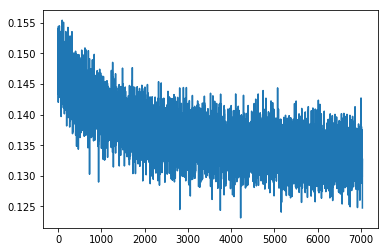

In [35]:
# plot losses
plt.plot(losses)

In [ ]:
######################################
# Affichage du gradient
# Ne marche pas à l'ENSEEITH
# RuntimeError: the derivative for 'target' is not implemented with binary_cross_entropy
# 
# Méthode : 
# - normaliser les valeurs du tableau Tab_Gradient construit pendant l'opération de train
# - ploter le tableau       

In [25]:
##https://www.kdnuggets.com/2018/04/getting-started-pytorch-understanding-automatic-differentiation.html/2

In [26]:
##plot the gradient mean value for each FC layer across training
#from torch.autograd import Variable
#for batch_idx, (data, _) in enumerate(train_loader):
#   gradient, *_ = train_loader.dataset
#    #print(f"Gradient of w{batch_idx} w.r.t to L: {gradient}")
#plt.plot(gradient)

In [27]:
##https://stackoverflow.com/questions/43451125/pytorch-what-are-the-gradient-arguments

In [28]:
#from torch.autograd import Variable
#import torch
#x = Variable(torch.FloatTensor(train_loader), requires_grad=True)
## or we can directly backprop using loss
#loss.backward() # equivalent to loss.backward(torch.FloatTensor([1.0]))
#print(x.grad.data)   

In [29]:
# Affichage du temps d execution
print("Temps d execution : %s secondes ---" % round((time.time() - start_time),1))

Temps d execution : 33.0 secondes ---
